In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '../../../'))

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['HOME'] = '/data25/wuqin'

In [2]:
import torch
from src.arguments import ModelArguments, DataArguments
from src.model.model import MMEBModel
from src.model.processor import load_processor, QWEN2_VL, VLM_IMAGE_TOKENS, Qwen2_VL_process_fn
from src.utils import batch_to_device
from experiments.examples.qwen2vl.utils import show_tensor_image, split_to_grid, show_grid, tensor2pil
from experiments.examples.qwen2vl.vggt_utils import load_and_preprocess_images


# 初始化模型
model_args = ModelArguments(
    model_name='VLM2Vec/VLM2Vec-V2.0',
    pooling='last',
    normalize=True,
    model_backbone='qwen2_vl',
    lora=True
)
data_args = DataArguments()

processor = load_processor(model_args, data_args)
model = MMEBModel.load(model_args)
model = model.to('cuda', dtype=torch.bfloat16)
model = model.eval()

/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-07-31 01:07:54,126] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
[2025-07-31 01:07:54,134] DEBUG [git.cmd:1270] Popen(['git', 'version'], cwd=/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl, stdin=None, shell=False, universal_newlines=False)
/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
[2025-07-31 01:07:54,715] DEBUG [matplotlib:342]

DropoutAddRMSNorm of flash_attn is not installed!!!


[2025-07-31 01:07:55,002] DEBUG [matplotlib:342] CACHEDIR=/data25/wuqin/.cache/matplotlib
[2025-07-31 01:07:55,005] DEBUG [matplotlib.font_manager:1635] Using fontManager instance from /data25/wuqin/.cache/matplotlib/fontlist-v390.json
[2025-07-31 01:07:55,200] INFO [src.utils:21] Loading processor from: VLM2Vec/VLM2Vec-V2.0
[2025-07-31 01:07:55,204] DEBUG [urllib3.connectionpool:1049] Starting new HTTPS connection (1): hf-mirror.com:443
[2025-07-31 01:07:56,734] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/preprocessor_config.json HTTP/1.1" 307 0
[2025-07-31 01:07:56,829] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /api/resolve-cache/models/VLM2Vec/VLM2Vec-V2.0/e39ff079b8275ef876d3656da8c0bddbff3c4dde/preprocessor_config.json HTTP/1.1" 200 0
[2025-07-31 01:07:57,088] DEBUG [urllib3.connectionpool:544] https://hf-mirror.com:443 "HEAD /VLM2Vec/VLM2Vec-V2.0/resolve/main/tokenizer_config.json HTTP/1.1" 307 0
[

In [5]:
from vggt_utils import load_and_preprocess_images
img = load_and_preprocess_images(["/data25/wuqin/projects/FlagEmbedding/research/visual_bge/vl_query_samples/test6/IMG_1786.jpg"])
print(img.shape)

torch.Size([1, 3, 392, 518])


[2025-07-31 01:19:15,933] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[2025-07-31 01:19:15,940] DEBUG [matplotlib.pyplot:497] Loaded backend module://matplotlib_inline.backend_inline version unknown.


[2025-07-31 01:19:15,953] DEBUG [matplotlib.font_manager:1471] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2025-07-31 01:19:15,955] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2025-07-31 01:19:15,955] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2025-07-31 01:19:15,955] DEBUG [matplotlib.font_manager:1483] findfont: score(FontEntry(fname='/data25/wuqin/miniforge3/envs/vlm2vec/lib/python3.11/site-packages/matplotlib/mpl-da

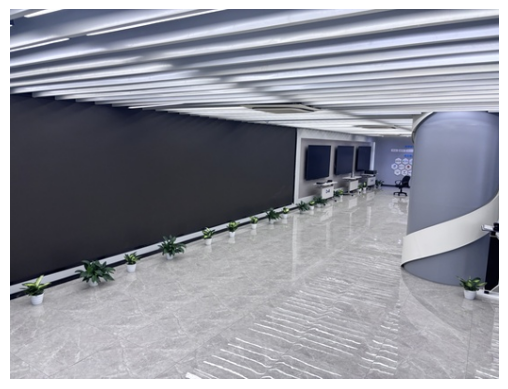

In [6]:
from utils import show_tensor_image
show_tensor_image(img)

## 多模态推理

输入图像文本对，将进入 LLM 之前的文本 embedding 的平均与图片 embedding 进行相似度计算

In [8]:
def get_image_embeddings(visual, image_grid_thw, pixel_values):
    bsz = len(image_grid_thw)
    image_grid_thw = [image_grid_thw[i] if image_grid_thw[i] is not None and image_grid_thw[i].sum() > 0 else None for i in range(bsz)]
    idx_w_image = [mid for mid, isize in enumerate(image_grid_thw) if isize is not None]
    if len(idx_w_image) > 0:
        merged_inputs_embeds = []
        if len(idx_w_image):
            valid_pixel_values = [pixel_values[i] if isinstance(pixel_values[i], torch.Tensor) else torch.from_numpy(pixel_values[i]) for i in idx_w_image]
            valid_pixel_values = torch.cat(valid_pixel_values)  # shape=[BS*n_patch,C*H*W]
            valid_grid_thw = [image_grid_thw[i] if isinstance(image_grid_thw[i], torch.Tensor) else torch.from_numpy(image_grid_thw[i]) for i in idx_w_image]
            valid_grid_thw = torch.cat(valid_grid_thw)  # shape=[BS,H,W]

            valid_pixel_values = valid_pixel_values.type(visual.get_dtype())
            image_embeds = visual(valid_pixel_values, grid_thw=valid_grid_thw)
    return image_embeds

def get_text_embeddings(embed_tokens, input_ids):
    return embed_tokens(input_ids)

In [26]:
from utils import tensor2pil
prompt = "绿植"
inputs = processor(text=f'{VLM_IMAGE_TOKENS[QWEN2_VL]} {prompt}',
                images=tensor2pil(img[0]),
                return_tensors="pt")
inputs = {key: value.to('cuda') for key, value in inputs.items()}
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(0)
inputs['image_grid_thw'] = inputs['image_grid_thw'].unsqueeze(0)
text_inputs_id = inputs['input_ids'][inputs['input_ids'] != model.encoder.config.image_token_id].unsqueeze(0)
print(text_inputs_id.shape)
with torch.no_grad():
    query_emb = torch.mean(get_text_embeddings(model.encoder.model.model.embed_tokens, text_inputs_id), dim=1)
    candi_embs = get_image_embeddings(model.encoder.visual, inputs['image_grid_thw'], inputs['pixel_values'])

# 归一化embeddings
candi_embs = torch.nn.functional.normalize(candi_embs, dim=-1)
query_emb = torch.nn.functional.normalize(query_emb, dim=-1)
print(f"查询embedding形状: {query_emb.shape}, patch embeddings形状: {candi_embs.shape}")

torch.Size([1, 3])
查询embedding形状: torch.Size([1, 1536]), patch embeddings形状: torch.Size([252, 1536])


In [31]:
sims = model.compute_similarity(query_emb, candi_embs)
sims = sims.float()
sims = sims.view(14, 18).cpu()
print(sims.shape)

torch.Size([14, 18])


torch.Size([14, 18, 28, 28, 3])
Grid shape: 14 blocks of size 28x28


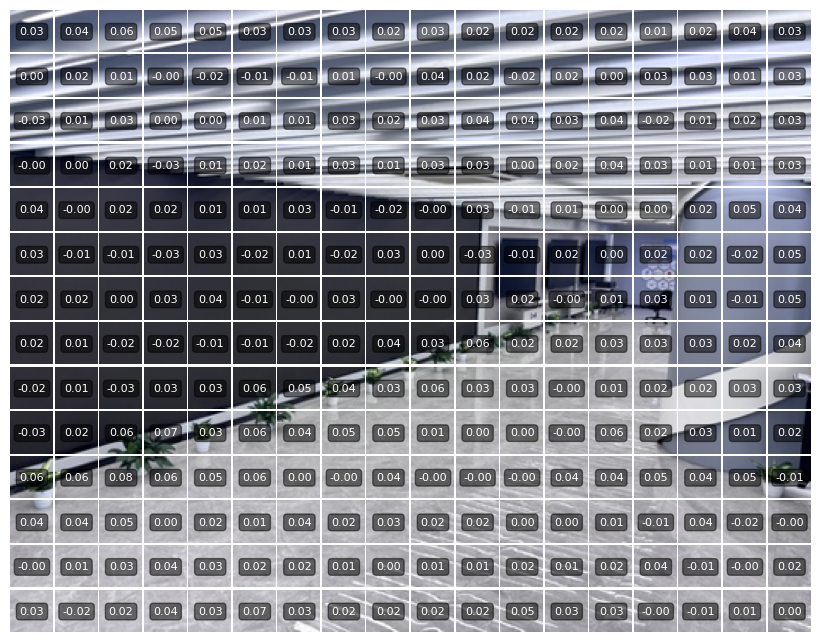

In [32]:
from utils import show_grid, split_to_grid
grid = split_to_grid(img[0], (14, 18)).cpu()
print(grid.shape)
show_grid(grid, sims)

Grid shape: 14 blocks of size 28x28


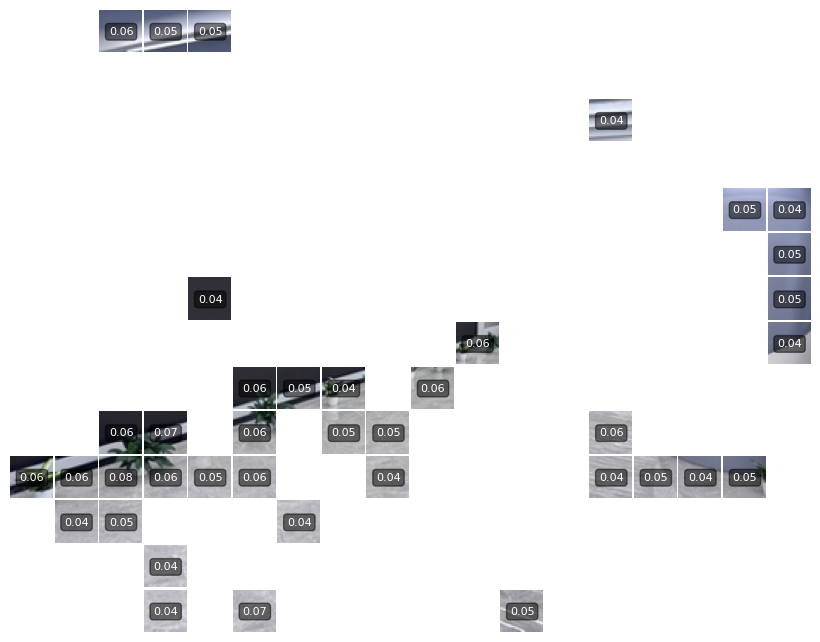

In [38]:
show_grid(grid, sims, mask=sims>0.04)